# Ensemble multi-agent pattern

In many domains, combining multiple independent solutions produces more reliable results than any single solution alone. This principle - the wisdom of crowds - applies to AI systems as well. Just as polling multiple experts and aggregating their opinions often yields better predictions than relying on a single expert, AI agents can benefit from ensemble approaches.

The ensemble multi-agent pattern is an approach where multiple independent agents solve the same problem, then their outputs are combined through aggregation, voting or averaging to produce a final answer. Each agent works in isolation without seeing others' solutions until the aggregation phase. This pattern is particularly valuable for:
- Tasks where diversity of approaches improves robustness.
- Problems where single agents might have biases or blindspots.
- Scenarios requiring high confidence and reliability.
- Situations where we want to reduce variance in outputs.

In this notebook, we will implement an ensemble multi-agent system with truly independent agents:
1. **Conservative agent:** Independent agent with low temperature for logical, systematic reasoning.
2. **Balanced agent:** Independent agent with medium temperature for pragmatic reasoning.
3. **Creative agent:** Independent agent with high temperature for exploratory, novel insights.
4. **Ensemble coordinator:** Orchestrates parallel invocation and aggregates results.

This demonstrates how multiple independent agents, each potentially using different reasoning strategies, can be combined to produce more robust and reliable answers than any single agent.

In [1]:
import os
from typing import TypedDict, Sequence, Annotated, List
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
import wikipedia

### Initialize the language models
In an ensemble system, we want diversity among the agents to maximize the benefit of aggregation. We create this diversity through different temperature settings - each agent gets its own LLM configuration.

In [2]:
# Initialize different LLM configurations for ensemble diversity
# Conservative Agent: Low temperature for consistent, logical reasoning
llm_conservative = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.0)

# Balanced Agent: Medium temperature for balanced reasoning
llm_balanced = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.5)

# Creative Agent: Higher temperature for creative, diverse reasoning
llm_creative = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.9)

# Aggregator: Medium-low temperature for balanced synthesis
llm_aggregator = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.3)

We create four different LLM instances with varying temperatures. The conservative agent is deterministic (temp=0.0), the balanced agent is moderate (temp=0.5), and the creative agent is exploratory (temp=0.9). This temperature diversity helps ensure we get different perspectives on the same problem, which is key to effective ensembling.

## Part 1: Build independent solver agents
Each solver agent is a complete, independent agent with its own state and graph. Each agent solves the problem independently with a different reasoning style.

### Conservative agent - Independent agent
This agent uses low temperature for consistent, logical, systematic reasoning.

In [3]:
# Define state for conservative agent - this agent's independent state
class ConservativeAgentState(TypedDict):
    """State for independent Conservative Agent."""
    # The messages field stores this agent's conversation history
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The question this agent is solving
    question: str
    # This agent's solution
    solution: str

def conservative_solve(state: ConservativeAgentState):
    """Conservative agent solves the problem with logical, systematic reasoning."""
    # System prompt defines this agent's approach
    system_prompt = SystemMessage(
        content="""You are a Conservative Solver Agent with a logical, systematic approach.
        
        Your task: Solve the user's question independently.
        - Use careful, step-by-step reasoning
        - Rely on well-established facts and logic
        - Be thorough and systematic
        - Use tools if needed to verify information
        - Prioritize accuracy and reliability over novelty
        
        You are part of an ensemble - other agents are solving this independently too.
        Provide your best complete answer.
        """
    )
    
    # Create prompt based on the question
    user_message = HumanMessage(content=state["question"])
    
    # Agent solves the problem
    response = llm_conservative.invoke([system_prompt, user_message])
    
    # Extract solution
    solution_text = response.content if response.content else ""
    
    # Execute any tool calls if needed
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            # Execute the tool
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
                solution_text += f"\n\n[Tool Result: {result}]"
    
    # Return updated state with solution
    return {
        "solution": solution_text,
        "messages": [AIMessage(content=f"[Conservative Solution]\n{solution_text}")]
    }

# Build conservative agent's graph - this is an independent agent
conservative_graph = StateGraph(ConservativeAgentState)

# Add node for conservative agent's workflow
conservative_graph.add_node("solve", conservative_solve)  # Solve the problem

# Define conservative agent's workflow: solve and finish
conservative_graph.add_edge(START, "solve")
conservative_graph.add_edge("solve", END)

# Compile into an independent agent
conservative_agent = conservative_graph.compile()

The conservative agent is a complete, independent agent. It has its own state (`ConservativeAgentState`), its own graph, and is compiled separately. This agent prioritizes accuracy and systematic reasoning with `temperature=0.0`.

### Balanced agent - Independent agent
This agent uses medium temperature for balanced, pragmatic reasoning.

In [4]:
# Define state for balanced agent - this agent's independent state
class BalancedAgentState(TypedDict):
    """State for independent Balanced Agent."""
    # The messages field stores this agent's conversation history
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The question this agent is solving
    question: str
    # This agent's solution
    solution: str

def balanced_solve(state: BalancedAgentState):
    """Balanced agent solves the problem with pragmatic, balanced reasoning."""
    # System prompt defines this agent's approach
    system_prompt = SystemMessage(
        content="""You are a Balanced Solver Agent with a pragmatic, balanced approach.
        
        Your task: Solve the user's question independently.
        - Balance analytical rigor with practical insights
        - Consider multiple perspectives
        - Be comprehensive but concise
        - Use tools if they add value
        - Balance established knowledge with new insights
        
        You are part of an ensemble - other agents are solving this independently too.
        Provide your best complete answer.
        """
    )
    
    # Create prompt based on the question
    user_message = HumanMessage(content=state["question"])
    
    # Agent solves the problem
    response = llm_balanced.invoke([system_prompt, user_message])
    
    # Extract solution
    solution_text = response.content if response.content else ""
    
    # Execute any tool calls if needed
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            # Execute the tool
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
                solution_text += f"\n\n[Tool Result: {result}]"
    
    # Return updated state with solution
    return {
        "solution": solution_text,
        "messages": [AIMessage(content=f"[Balanced Solution]\n{solution_text}")]
    }

# Build balanced agent's graph - this is an independent agent
balanced_graph = StateGraph(BalancedAgentState)

# Add node for balanced agent's workflow
balanced_graph.add_node("solve", balanced_solve)  # Solve the problem

# Define balanced agent's workflow: solve and finish
balanced_graph.add_edge(START, "solve")
balanced_graph.add_edge("solve", END)

# Compile into an independent agent
balanced_agent = balanced_graph.compile()

The balanced agent is also a complete, independent agent with its own state, graph, and compilation. It uses `temperature=0.5` for balanced, pragmatic reasoning that considers multiple perspectives.

### Creative agent - Independent agent
This agent uses high temperature for creative, exploratory reasoning.

In [5]:
# Define state for creative agent - this agent's independent state
class CreativeAgentState(TypedDict):
    """State for independent Creative Agent."""
    # The messages field stores this agent's conversation history
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The question this agent is solving
    question: str
    # This agent's solution
    solution: str

def creative_solve(state: CreativeAgentState):
    """Creative Agent solves the problem with exploratory, creative reasoning."""
    # System prompt defines this agent's approach
    system_prompt = SystemMessage(
        content="""You are a Creative Solver Agent with an exploratory, innovative approach.
        
        Your task: Solve the user's question independently.
        - Think creatively and consider novel angles
        - Explore less obvious connections and insights
        - Be willing to take informed intellectual risks
        - Use tools to discover interesting information
        - Look for innovative perspectives others might miss
        
        You are part of an ensemble - other agents are solving this independently too.
        Provide your best complete answer.
        """
    )
    
    # Create prompt based on the question
    user_message = HumanMessage(content=state["question"])
    
    # Agent solves the problem
    response = llm_creative.invoke([system_prompt, user_message])
    
    # Extract solution
    solution_text = response.content if response.content else ""
    
    # Execute any tool calls if needed
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            # Execute the tool
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
                solution_text += f"\n\n[Tool Result: {result}]"
    
    # Return updated state with solution
    return {
        "solution": solution_text,
        "messages": [AIMessage(content=f"[Creative Solution]\n{solution_text}")]
    }

# Build creative agent's graph - this is an independent agent
creative_graph = StateGraph(CreativeAgentState)

# Add node for creative agent's workflow
creative_graph.add_node("solve", creative_solve)  # Solve the problem

# Define creative agent's workflow: solve and finish
creative_graph.add_edge(START, "solve")
creative_graph.add_edge("solve", END)

# Compile into an independent agent
creative_agent = creative_graph.compile()

The creative agent is the third independent agent with its own state, graph, and compilation. It uses `temperature=0.9` for exploratory reasoning that surfaces novel insights and less obvious connections.

## Part 2: Build the ensemble coordinator
The coordinator orchestrates parallel invocation of all three solver agents and then aggregates their independent solutions.

### Ensemble coordinator - Orchestration agent

In [6]:
# Define state for the ensemble coordinator
class EnsembleCoordinatorState(TypedDict):
    """State for the ensemble coordination system."""
    # The messages field stores the full conversation history
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The user's question
    user_question: str
    # Conservative agent's solution
    solution_conservative: str
    # Balanced agent's solution
    solution_balanced: str
    # Creative agent's solution
    solution_creative: str
    # Final aggregated answer
    final_answer: str

def coordinate_parallel_solving(state: EnsembleCoordinatorState):
    """Coordinator invokes all three solver agents in parallel."""
    # Invoke all three independent agents with the same question
    # In a production system, these could truly run in parallel - For this demonstration, we invoke them sequentially but conceptually they're parallel
    
    question = state["user_question"]
    
    # Invoke conservative agent (independent)
    conservative_result = conservative_agent.invoke({
        "question": question,
        "solution": ""
    })
    solution_conservative = conservative_result["solution"]
    
    # Invoke balanced agent (independent)
    balanced_result = balanced_agent.invoke({
        "question": question,
        "solution": ""
    })
    solution_balanced = balanced_result["solution"]
    
    # Invoke creative agent (independent)
    creative_result = creative_agent.invoke({
        "question": question,
        "solution": ""
    })
    solution_creative = creative_result["solution"]
    
    # Return updated coordinator state with all three solutions
    return {
        "solution_conservative": solution_conservative,
        "solution_balanced": solution_balanced,
        "solution_creative": solution_creative,
        "messages": [
            AIMessage(content=f"[Conservative Agent Solution]\n{solution_conservative[:200]}..."),
            AIMessage(content=f"[Balanced Agent Solution]\n{solution_balanced[:200]}..."),
            AIMessage(content=f"[Creative Agent Solution]\n{solution_creative[:200]}...")
        ]
    }

def coordinate_aggregation(state: EnsembleCoordinatorState):
    """Coordinator aggregates all independent solutions into final answer."""
    # System prompt defines the aggregator's role
    system_prompt = SystemMessage(
        content="""You are an Aggregator synthesizing solutions from an ensemble of independent agents.
        
        You have received three independent solutions to the same question:
        - Conservative Solution: Systematic, logical, reliable
        - Balanced Solution: Pragmatic, multi-perspective
        - Creative Solution: Innovative, exploratory
        
        Your task: Synthesize the best final answer by:
        - Identifying areas where solutions agree (high confidence)
        - Evaluating areas where solutions differ (examine each perspective)
        - Taking the best insights and ideas from all three
        - Creating a comprehensive answer that's better than any single solution
        - Noting if one approach seems clearly superior for this specific question
        
        The ensemble approach works best when you leverage the diversity of perspectives.
        """
    )
    
    # Get all three solutions and the original question
    question = state["user_question"]
    conservative_sol = state["solution_conservative"]
    balanced_sol = state["solution_balanced"]
    creative_sol = state["solution_creative"]
    
    # Create aggregation prompt
    aggregation_prompt = HumanMessage(
        content=f"""Original Question: {question}
        
        Conservative Solution (Systematic/Logical):
        {conservative_sol}
        
        Balanced Solution (Pragmatic/Multi-perspective):
        {balanced_sol}
        
        Creative Solution (Innovative/Exploratory):
        {creative_sol}
        
        Aggregate these three independent solutions into the best possible final answer."""
    )
    
    # Aggregator synthesizes all solutions
    response = llm_aggregator.invoke([system_prompt, aggregation_prompt])
    final_answer = response.content
    
    # Return updated coordinator state with final answer
    return {
        "final_answer": final_answer,
        "messages": [AIMessage(content=f"[Final Ensemble Answer]\n{final_answer}")]
    }

# Build the ensemble coordinator graph
coordinator_graph = StateGraph(EnsembleCoordinatorState)

# Add coordinator nodes
coordinator_graph.add_node("parallel_solving", coordinate_parallel_solving)
coordinator_graph.add_node("aggregation", coordinate_aggregation)

# Define the ensemble workflow
# Phase 1: Invoke all solver agents in parallel
coordinator_graph.add_edge(START, "parallel_solving")

# Phase 2: Aggregate all solutions
coordinator_graph.add_edge("parallel_solving", "aggregation")
coordinator_graph.add_edge("aggregation", END)

# Compile the coordinator
ensemble_system = coordinator_graph.compile()

The ensemble coordinator orchestrates the entire multi-agent ensemble process:
1. Parallel solving - Invokes three independent agents (conservative, balanced, creative) with the same question.
2. Aggregation - Synthesizes all three independent solutions into a final answer.

Each invocation of `conservative_agent.invoke()`, `balanced_agent.invoke()`, and `creative_agent.invoke()` runs a complete, independent agent with its own state and graph. The diversity in temperature settings ensures each agent approaches the problem differently.

### Visualize the ensemble coordinator workflow

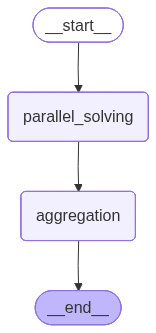

In [7]:
# Visualize the ensemble coordinator workflow
display(
    Image(
        ensemble_system.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

The visualization shows how the coordinator orchestrates parallel solving followed by aggregation.

## Part 3: Run the ensemble system
Let's see the ensemble multi-agent pattern in action with a question where diverse perspectives and independent reasoning add value.

### Example: Space exploration challenges

In [8]:
# Example: A question that benefits from ensemble approach
user_question = "What are the main challenges and opportunities in space exploration?"

# Initialize state with the user's question
initial_state = EnsembleCoordinatorState(
    messages=[HumanMessage(content=user_question)],
    user_question=user_question,
    solution_conservative="",
    solution_balanced="",
    solution_creative="",
    final_answer=""
)

# Run the ensemble multi-agent system
print("=== Starting Ensemble Multi-Agent System ===")
print(f"\nQuestion: {user_question}\n")

# Invoke the ensemble multi-agent system 
result = ensemble_system.invoke(initial_state)

# Display the results
print("\n=== Independent Solutions ===")
print(f"\n{'='*70}")
print("Conservative Agent Solution (temp=0.0, systematic):")
print(f"{'='*70}")
print(result["solution_conservative"][:500] + "..." if len(result["solution_conservative"]) > 500 else result["solution_conservative"])

print(f"\n{'='*70}")
print("Balanced Agent Solution (temp=0.5, pragmatic):")
print(f"{'='*70}")
print(result["solution_balanced"][:500] + "..." if len(result["solution_balanced"]) > 500 else result["solution_balanced"])

print(f"\n{'='*70}")
print("Creative Agent Solution (temp=0.9, exploratory):")
print(f"{'='*70}")
print(result["solution_creative"][:500] + "..." if len(result["solution_creative"]) > 500 else result["solution_creative"])

print(f"\n{'='*70}")
print("FINAL AGGREGATED ENSEMBLE ANSWER:")
print(f"{'='*70}")
print(result["final_answer"])
print(f"{'='*70}\n")

=== Starting Ensemble Multi-Agent System ===

Question: What are the main challenges and opportunities in space exploration?


=== Independent Solutions ===

Conservative Agent Solution (temp=0.0, systematic):
Space exploration presents a unique set of challenges and opportunities that can be categorized into several key areas. Below is a systematic analysis of these challenges and opportunities:

### Challenges in Space Exploration

1. **Technical Challenges**:
   - **Engineering and Design**: Developing spacecraft that can withstand extreme conditions (radiation, vacuum, temperature variations) is complex and costly.
   - **Propulsion Systems**: Current propulsion technologies limit the speed and ef...

Balanced Agent Solution (temp=0.5, pragmatic):
Space exploration presents a unique landscape of challenges and opportunities that can significantly impact scientific advancement, international collaboration, and technological innovation. Here’s a balanced overview:

### Main Challenge

In this example, we see the ensemble pattern in action:

1. **Conservative agent:** Provides systematic analysis of established challenges (radiation, life support, cost) and proven opportunities (scientific discovery, resource utilization). Focuses on well-documented facts and logical reasoning.
2. **Balanced agent:** Offers pragmatic perspective balancing technical challenges with economic and political opportunities. Considers multiple viewpoints and practical implications.
3. **Creative agent:** Explores innovative angles like space-based manufacturing, interplanetary internet, or novel propulsion. May surface less obvious opportunities that other agents miss.
4. **Aggregation:** The coordinator identifies consensus areas (high confidence findings like radiation and life support challenges) and unique insights from each agent (creative opportunities, pragmatic considerations, systematic analysis). The final answer combines systematic rigor, pragmatic balance, and creative vision.

The ensemble approach produces a more comprehensive, robust answer than any single agent by:
- Reducing variance: Conservative agent provides reliability.
- Balancing perspectives: Balanced agent ensures practicality.
- Surfacing insights: Creative agent finds novel angles.
- Aggregating wisdom: Final answer benefits from all three.

This pattern is ideal for tasks where reliability matters, single solutions might have blind spots, or where diversity of approaches improves outcomes. The ensemble ensures the final answer benefits from multiple independent perspectives, producing more robust results than any single agent.